## Backing out CPI from Wage Data

Michael Wooley, [michael.wooley@us.gt.com](mailto:michael.wooley@us.gt.com)

Use non-adjusted average hourly earnings. Compare the real and nominal series to get it.

In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Set up the series that we are going to compare to back out the price index:

In [3]:
# Comparison 1: All sectors
# Average weekly earnings of production and nonsupervisory employees, 1982-84 dollars, total private, not seasonally adjusted
nom = 'CEU0500000031'

# Average weekly earnings of production and nonsupervisory employees, total private, not seasonally adjusted
rel = 'CEU0500000030'

sid = [(rel, nom)]

# Comparison 2: Goods-Providing
# Average weekly earnings of production and nonsupervisory employees, goods-producing, not seasonally adjusted
nom = 'CEU0600000030'
# Average weekly earnings of production and nonsupervisory employees, 1982-84 dollars, goods-producing, not seasonally adjusted
rel = 'CEU0600000031'

sid.append((rel, nom))

# Comparison 3: Service-Providing
# Average weekly earnings of production and nonsupervisory employees, private service-providing, not seasonally adjusted
nom = 'CEU0800000030'

# Average weekly earnings of production and nonsupervisory employees, 1982-84 dollars, private service-providing, not seasonally adjusted
rel = 'CEU0800000031'

sid.append((rel, nom))

Now let's get the data. (Here I download directly from web to demonstrate that this is not an issue with any pre-processing.)

In [4]:
# Import
df_ = pd.read_csv(
      'https://download.bls.gov/pub/time.series/ce/ce.data.0.AllCESSeries',
      sep='\t',
      encoding='ascii',
      header=None,
      skiprows=1,
      low_memory=False
    )

In [5]:
# Rename the columns
df_.columns = ['series_id', 'year', 'period', 'value', 'footnote']
# Get rid of NA rows
df_.dropna(axis=1, how='all', inplace=True)
# Strip white space
df_ = df_.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
# Isolate the variables of interest
sid_t = tuple([s for sdi_i in sid for s in sdi_i ])
df_ = df_.loc[df_['series_id'].isin(sid_t)]
# Get rid of annual averages
df_.drop(df_.index[df_['period'].isin(['M13', 'A01'])], inplace=True)
# Make dates
df_['date'] = df_.apply(lambda d: pd.Timestamp(d['year'], int(d['period'][1:]),1),axis=1)

df_.head()

,series_id,year,period,value,footnote,date
3598122,CEU0500000030,1964,M01,95.00,,1964-01-01
3598123,CEU0500000030,1964,M02,95.50,,1964-02-01
3598124,CEU0500000030,1964,M03,95.75,,1964-03-01
3598125,CEU0500000030,1964,M04,96.38,,1964-04-01
3598126,CEU0500000030,1964,M05,97.02,,1964-05-01


Now we create two versions of the derived index:

1. _Version 1_ = real / nominal * 100
1. _Version 2_ = nominal / real * 100

So we just flip these.

In [6]:
cpi_v1,cpi_v2 = [], []
print('Import data and check to ensure 1982-84~=100 for both versions:')
for ii,(sid_i,nm) in enumerate(zip(sid, ['All', 'Goods', 'Services'])):
    df = df_.loc[df_['series_id'].isin(sid_i)] #pd.read_sql('SELECT * FROM ces_data WHERE series_id IN {}'.format(sid_i), conn, parse_dates=['date'])
    df = df.pivot(columns='series_id', index='date', values='value').rename(columns={sid_i[0]: 'real', sid_i[1]: 'nominal'})

    # Construct the CPI (of either type)
    df['cpi_v1'] = df['real'] / df['nominal'] * 100
    df['cpi_v2'] = df['nominal'] / df['real'] * 100

    # Check to make sure that the mean of 1982-1984 is 100 (as advertised)
    pp = [df.loc[(df.index >= pd.Timestamp(1982,1,1)) & (df.index < pd.Timestamp(1985,1,1)), 'cpi_v1'].mean(), 
     df.loc[(df.index >= pd.Timestamp(1982,1,1)) & (df.index < pd.Timestamp(1985,1,1)), 'cpi_v2'].mean()]
    print('\t1982-84 Mean Index for {}: {}'.format(nm, pp))

    # Merge to check
    dfi = df[['cpi_v1']].reset_index()
    dfi['name'] = nm
    cpi_v1.append(dfi)
    dfi = df[['cpi_v2']].reset_index()
    dfi['name'] = nm
    cpi_v2.append(dfi)
    
cpi_v1 = pd.concat(cpi_v1).pivot(index='date', values='cpi_v1', columns='name').dropna()
cpi_v2 = pd.concat(cpi_v2).pivot(index='date', values='cpi_v2', columns='name').dropna()

Import data and check to ensure 1982-84~=100 for both versions:
	1982-84 Mean Index for All: [100.00034869187249, 100.0850012777281]
	1982-84 Mean Index for Goods: [100.08541305274392, 99.99994538356623]
	1982-84 Mean Index for Services: [100.08552539793358, 99.99985699479852]


From the above we see that both versions of the price index have means that are quite close to the advertised 100.

Now plot each of the versions:

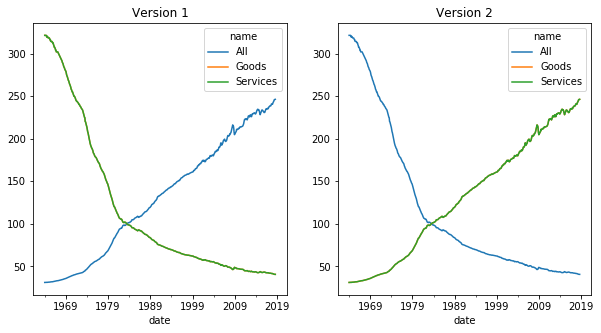

In [7]:
f, axes = plt.subplots(1,2, figsize=(10,5))

cpi_v1.plot(title='Version 1', ax=axes[0])
cpi_v2.plot(title='Version 2', ax=axes[1])

From this we notice:

1. The goods and services indices are identical for both versions (Can be confirmed by looking at head of frame.)
1. The "Version 1" and "Version 2" indices appear to be flipped.

This can be confirmed by examining the data:

In [8]:
print('Version 1')
cpi_v1.tail()

Version 1


name,All,Goods,Services
date,,,
2018-04-01,244.605092,40.882149,40.881600
2018-05-01,245.772208,40.688933,40.689079
2018-06-01,246.195863,40.617848,40.618711
2018-07-01,246.156299,40.624657,40.625043
2018-08-01,246.334556,40.595415,40.594374


In [9]:
print('Version 2')
cpi_v2.tail()

Version 2


name,All,Goods,Services
date,,,
2018-04-01,40.882223,244.605538,244.608823
2018-05-01,40.688083,245.767071,245.766191
2018-06-01,40.618067,246.197190,246.191957
2018-07-01,40.624595,246.155924,246.153589
2018-08-01,40.595198,246.333236,246.339553


So it appears:

1. The goods and services indices are, in fact, equal for both versions.
1. The "All goods" index for version 1 is identical to the goods/services indices for version 2 (and vice versa).

_Note_ that the numbers won't be exactly equal to arbitrary precision due to the fact that the original input data was rounded to two decimal places.

Of course, we've only examined the tail of the data. As a final check, I look at the absolute maximum difference between the two sets of series:

In [10]:
print('Maximum absolute difference between "All" (v1) and mean of "Goods"/"Services" (v2): {}'.format(np.max(np.abs(cpi_v1['All'] - cpi_v2[['Goods', 'Services']].mean(axis=1)))))
print('Maximum absolute difference between "All" (v2) and mean of "Goods"/"Services" (v1): {}'.format(np.max(np.abs(cpi_v2['All'] - cpi_v1[['Goods', 'Services']].mean(axis=1)))))

Maximum absolute difference between "All" (v1) and mean of "Goods"/"Services" (v2): 0.006366744655338152
Maximum absolute difference between "All" (v2) and mean of "Goods"/"Services" (v1): 0.0077194828678557315


This confirms what was found in the plot above: The version 1 for "all" is essentially identical to the version 2 for goods/services.

## Conclusion

I am more than open to the possibility that something is messed up here. However, there appears to be a pretty big and systematic inconsistency.

If this is a genuine problem from the data then it will be necessary to re-examine all other CES wage series for similar issues.